In [ ]:
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
!ls

__MACOSX  sample_data  test  test.zip  train  train.zip  valid	valid.zip


In [ ]:
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('valid.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
train_dir = './train';
validation_dir = './valid';
test_dir = './test';

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 320 files belonging to 3 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 70 files belonging to 3 classes.


0 - гниль
1 - ржавчина
2 - парша

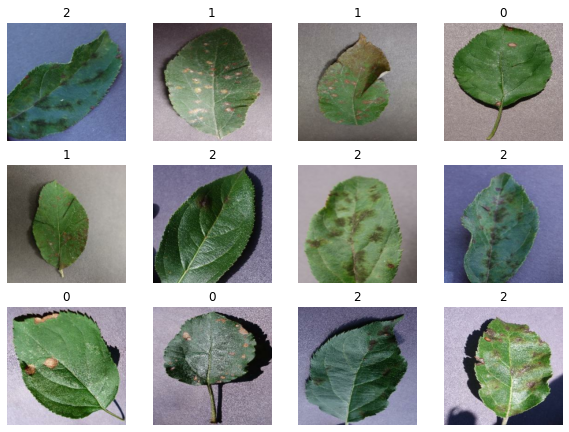

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# NO TEST DATA FOR THIS
test_dataset = image_dataset_from_directory(test_dir,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 90 files belonging to 1 classes.


In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([                          
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

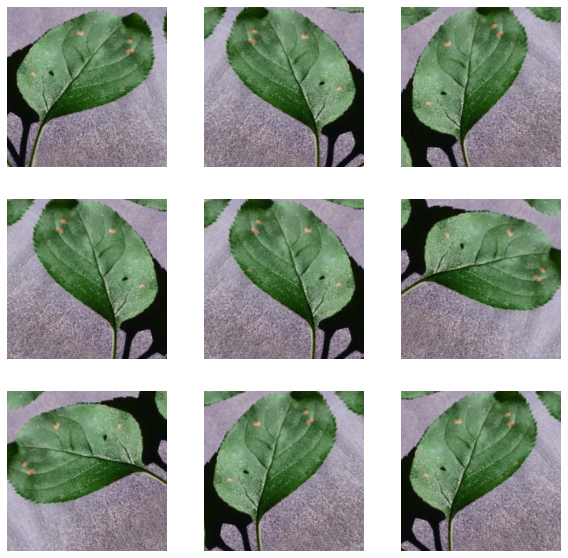

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 1s 44ms/step - loss: 10.6076 - accuracy: 0.2796


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 10.64
initial accuracy: 0.29


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
10/10 [==============================] - 4s 102ms/step - loss: 9.3929 - accuracy: 0.3063 - val_loss: 9.8432 - val_accuracy: 0.2714
Epoch 2/10
10/10 [==============================] - 1s 96ms/step - loss: 7.7616 - accuracy: 0.3344 - val_loss: 8.2597 - val_accuracy: 0.2714
Epoch 3/10
10/10 [==============================] - 1s 96ms/step - loss: 6.6118 - accuracy: 0.3531 - val_loss: 6.9664 - val_accuracy: 0.3000
Epoch 4/10
10/10 [==============================] - 1s 97ms/step - loss: 6.4745 - accuracy: 0.3469 - val_loss: 5.9577 - val_accuracy: 0.3000
Epoch 5/10
10/10 [==============================] - 1s 96ms/step - loss: 5.9548 - accuracy: 0.3625 - val_loss: 5.6472 - val_accuracy: 0.3714
Epoch 6/10
10/10 [==============================] - 1s 94ms/step - loss: 5.8988 - accuracy: 0.4062 - val_loss: 4.8808 - val_accuracy: 0.4000
Epoch 7/10
10/10 [==============================] - 1s 95ms/step - loss: 5.0578 - accuracy: 0.4250 - val_loss: 4.2938 - val_accuracy: 0.4571
Epoch 8/10
1

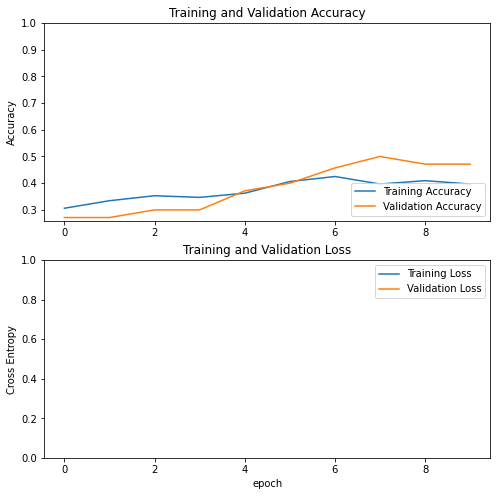

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
10/10 [==============================] - 6s 200ms/step - loss: 2.0626 - accuracy: 0.4201 - val_loss: 1.3014 - val_accuracy: 0.4857
Epoch 11/20
10/10 [==============================] - 2s 124ms/step - loss: 1.1226 - accuracy: 0.3319 - val_loss: 1.0986 - val_accuracy: 0.3857
Epoch 12/20
10/10 [==============================] - 2s 122ms/step - loss: 1.1250 - accuracy: 0.3900 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 13/20
10/10 [==============================] - 2s 123ms/step - loss: 1.0963 - accuracy: 0.4343 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 14/20
10/10 [==============================] - 2s 123ms/step - loss: 1.0892 - accuracy: 0.4001 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 15/20
10/10 [==============================] - 2s 126ms/step - loss: 1.0986 - accuracy: 0.4499 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 16/20
10/10 [==============================] - 2s 125ms/step - loss: 1.0919 - accuracy: 0.4260 - val_loss: 1.0986 - val_accuracy: 0.5000

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

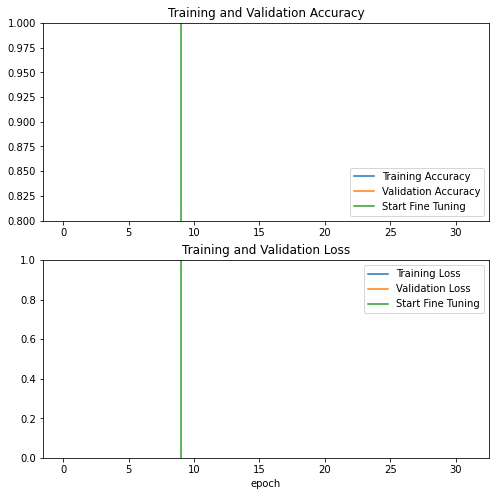

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


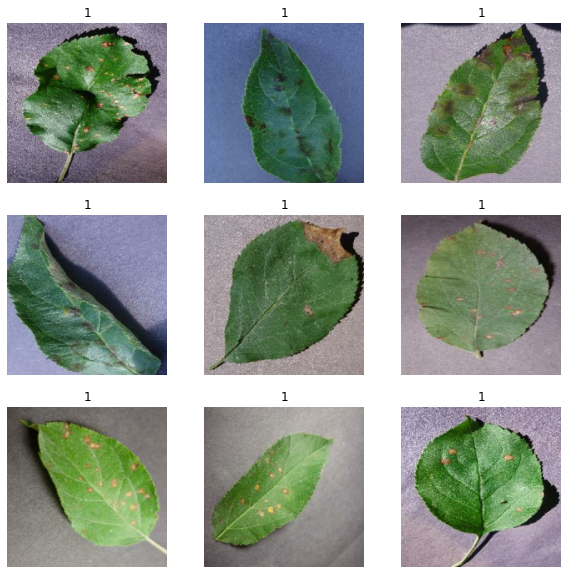

In [ ]:
#THIS CELL IS INCORRECT

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
# predictions = tf.where(predictions < 0.333, 0, tf.where(predictions < 0.666, 1, 2))
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

class: 2 with a 56.70 confidence.
class: 0 with a 51.38 confidence.
class: 0 with a 59.34 confidence.
class: 2 with a 84.11 confidence.
class: 2 with a 45.20 confidence.
class: 2 with a 48.58 confidence.
class: 2 with a 52.10 confidence.
class: 0 with a 34.29 confidence.
class: 0 with a 60.42 confidence.
class: 0 with a 48.54 confidence.
class: 2 with a 45.81 confidence.
class: 0 with a 67.20 confidence.
class: 2 with a 59.17 confidence.
class: 0 with a 54.53 confidence.
class: 2 with a 57.48 confidence.
class: 0 with a 53.08 confidence.
class: 2 with a 78.83 confidence.
class: 0 with a 75.19 confidence.
class: 0 with a 38.96 confidence.
class: 0 with a 40.89 confidence.
class: 2 with a 59.64 confidence.
class: 0 with a 58.95 confidence.
class: 0 with a 49.89 confidence.
class: 0 with a 54.53 confidence.
class: 0 with a 59.34 confidence.
class: 2 with a 51.44 confidence.
class: 2 with a 52.80 confidence.
class: 2 with a 69.56 confidence.
class: 1 with a 47.06 confidence.
class: 1 with 

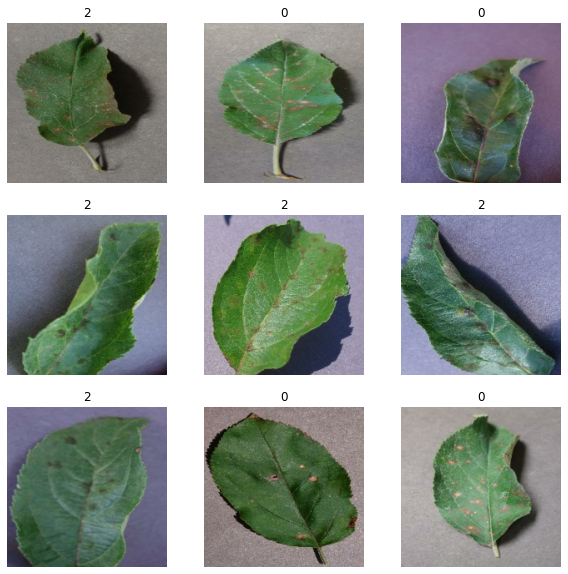

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

for i in range (32):
  score = tf.nn.softmax(predictions[i])
  print(
    "class: {} with a {:.2f} confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
  
predictions = [np.argmax(tf.nn.softmax(i)) for i in predictions]
  
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Image classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 320 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './valid',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 70 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2']


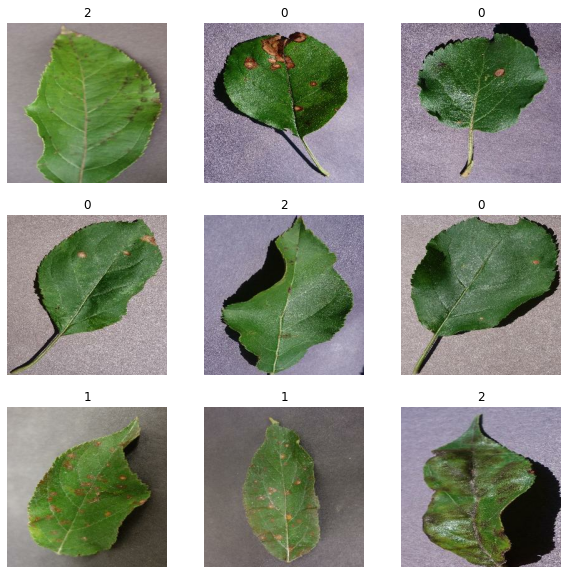

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.91372555


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = 3

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)      

In [ ]:
epochs=10
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 1s 62ms/step - loss: 3.1108 - accuracy: 0.3257 - val_loss: 1.0062 - val_accuracy: 0.4429
Epoch 2/10
10/10 [==============================] - 0s 41ms/step - loss: 0.8599 - accuracy: 0.7258 - val_loss: 0.4342 - val_accuracy: 0.8857
Epoch 3/10
10/10 [==============================] - 0s 41ms/step - loss: 0.3212 - accuracy: 0.9326 - val_loss: 0.3304 - val_accuracy: 0.8857
Epoch 4/10
10/10 [==============================] - 0s 41ms/step - loss: 0.1607 - accuracy: 0.9569 - val_loss: 0.0943 - val_accuracy: 0.9857
Epoch 5/10
10/10 [==============================] - 0s 41ms/step - loss: 0.0704 - accuracy: 0.9728 - val_loss: 0.1392 - val_accuracy: 0.9714
Epoch 6/10
10/10 [==============================] - 0s 40ms/step - loss: 0.1204 - accuracy: 0.9547 - val_loss: 0.0638 - val_accuracy: 0.9857
Epoch 7/10
10/10 [==============================] - 0s 41ms/step - loss: 0.0641 - accuracy: 0.9785 - val_loss: 0.0405 - val_accuracy: 0.9857
Epoch 8/10
10

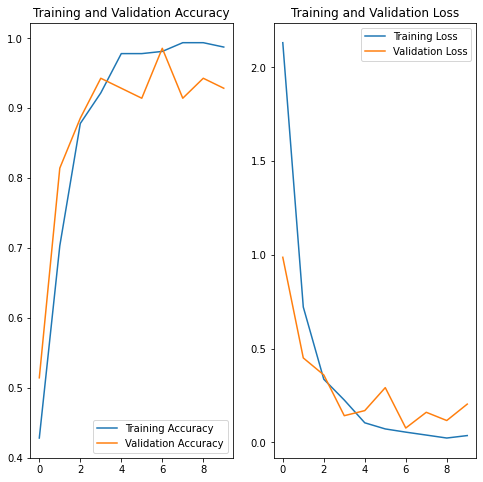

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

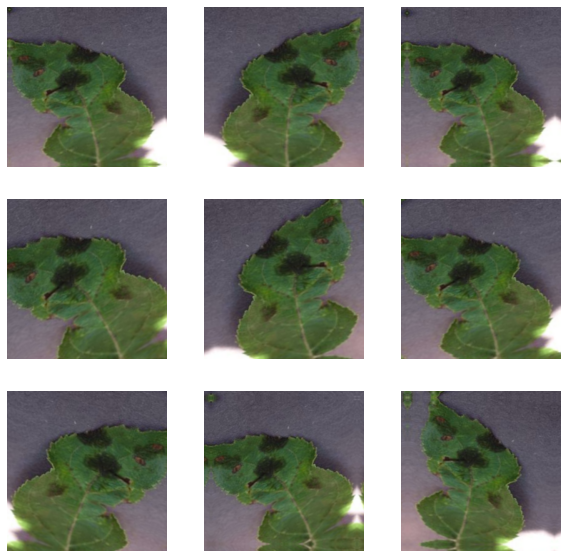

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model1 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, None, None, 3)     0         
_________________________________________________________________
rescaling_18 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)      

In [ ]:
epochs = 15
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 1s 64ms/step - loss: 2.6947 - accuracy: 0.3353 - val_loss: 1.0016 - val_accuracy: 0.4429
Epoch 2/15
10/10 [==============================] - 0s 43ms/step - loss: 1.0321 - accuracy: 0.3780 - val_loss: 0.7276 - val_accuracy: 0.5571
Epoch 3/15
10/10 [==============================] - 0s 43ms/step - loss: 0.7608 - accuracy: 0.6462 - val_loss: 0.3164 - val_accuracy: 0.9714
Epoch 4/15
10/10 [==============================] - 0s 44ms/step - loss: 0.4052 - accuracy: 0.8964 - val_loss: 0.1470 - val_accuracy: 0.9714
Epoch 5/15
10/10 [==============================] - 0s 43ms/step - loss: 0.4213 - accuracy: 0.8844 - val_loss: 0.1893 - val_accuracy: 0.9571
Epoch 6/15
10/10 [==============================] - 0s 44ms/step - loss: 0.2874 - accuracy: 0.9199 - val_loss: 0.1374 - val_accuracy: 0.9429
Epoch 7/15
10/10 [==============================] - 0s 43ms/step - loss: 0.2254 - accuracy: 0.9342 - val_loss: 0.0922 - val_accuracy: 0.9429
Epoch 8/15
10

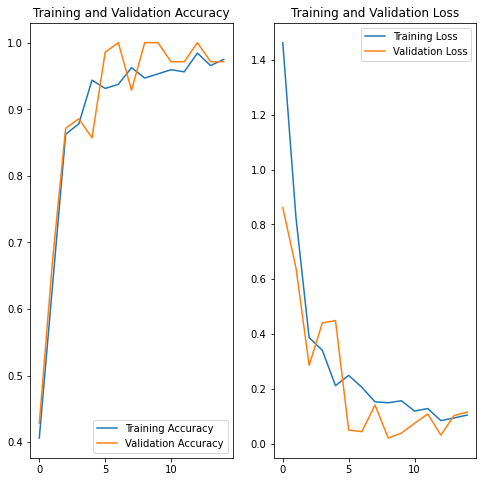

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = './test/0/1.jpg'


img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 1 with a 99.92 percent confidence.


In [ ]:
preds = []
for i in range(90):
  path = f'./test/0/{i}.jpg'
  img = keras.preprocessing.image.load_img(
      path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # maskPreds = model.predict(np.vstack(faces))
  predictions = model1.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  preds.append(np.argmax(score))


In [ ]:
# save csv sumbit
import pandas as pd
df = pd.DataFrame(preds, columns=['class'])
df.to_csv('preds.csv', index=False)

In [ ]:
# list of files in test dir
from os import listdir
from os.path import isfile, join
mypath = './test/0'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]